In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import sys
sys.path.append('../')
import default_style

In [2]:
TS_DATASET_FOLDER = os.path.join('..', 'dataset')
TS_PREPROC_FOLDER = os.path.join(TS_DATASET_FOLDER, 'preprocessed_traces')
DF_PREPROC_FILE = os.path.join(TS_PREPROC_FOLDER, 'preproc_ts.df')

TARGET = 'statement'
TRACES = 'syllables_02_STFT'

In [3]:
df = pd.read_csv(DF_PREPROC_FILE).drop(columns=['Unnamed: 0'])
df["actor_number"] = df.actor.apply(lambda x: int(x.split("_")[1]))
df.head()

,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,path,sex,begin_s,end_s,...,filtered_fourier_coeffs,syll_0_start_index,syll_1_start_index,syll_2_start_index,syll_3_start_index,syll_4_start_index,syll_5_start_index,syll_6_start_index,syll_7_start_index,actor_number
0,speech,neutral,normal,kids,1st,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.009833,2.252000,...,[1.9371510e-07 1.2311473e-02 1.1168692e-02 ......,0,1128,2240,3200,4304,5208,5808,7448,1
1,speech,neutral,normal,kids,2nd,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.068500,2.294667,...,[3.5017729e-07 2.6198970e-02 2.5683273e-02 ......,0,2008,3208,3880,4224,5112,5800,7352,1
2,speech,neutral,normal,dogs,1st,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.012000,2.238500,...,[2.49594450e-07 1.23483688e-02 1.06786685e-02 ...,0,2816,3352,3912,4296,5232,5880,7352,1
3,speech,neutral,normal,dogs,2nd,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.008833,2.187167,...,[1.1920929e-07 1.2154780e-02 1.6620707e-02 ......,0,1664,2664,3208,3672,4840,5448,7064,1
4,speech,calm,normal,kids,1st,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.023667,2.534167,...,[1.1920929e-07 2.0026902e-03 7.9688808e-04 ......,0,2088,3584,4832,5800,6944,7560,9056,1


In [4]:
traces_dict = {}
files = os.listdir(TS_PREPROC_FOLDER)

# SORRY PAOLINO BUT I HAVE A CHICCO PC AND I CANNOT LOAD IT ALL

# for file in files:

#     if file.endswith('.npy'):
#         file_path = os.path.join(TS_PREPROC_FOLDER, file)
#         # dictionary keys are the file names
#         key = os.path.splitext(file)[0]
#         # load array
#         traces_dict[key] = np.load(file_path, allow_pickle=True)

# traces_dict.keys()

file_path = os.path.join(TS_PREPROC_FOLDER, f"{TRACES}.npy")
traces_dict[TRACES] = np.load(file_path, allow_pickle=True)


In [5]:
traces = traces_dict[TRACES]
traces.shape

(2452, 27, 27)

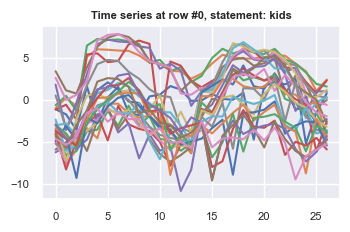

In [6]:
index = 0
statement = df['statement'][index]
plt.plot(traces[index])
plt.title(f'Time series at row #{index}, statement: {statement}')
plt.show()

C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\IPython\core\events.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


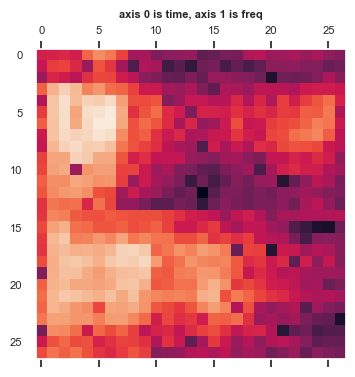

In [7]:
plt.matshow(traces[index]);plt.grid(ls="")
plt.title("axis 0 is time, axis 1 is freq");

In [91]:
from sklearn.model_selection import train_test_split

# Sets tests to be over actor 19 (excluded)
X_test = traces[df.actor_number > 19]
y_test = df[TARGET][df.actor_number > 19].to_numpy()

# Sets the train and validation inside actors < 19
X_train, X_val, y_train, y_val = train_test_split(  traces[df.actor_number <= 19], 
                                                    df[TARGET][df.actor_number <= 19].to_numpy(), 
                                                    test_size=0.2, random_state=100)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((1545, 27, 27), (387, 27, 27), (520, 27, 27), (1545,), (387,), (520,))

# CNN for statement and syllables 0&2

In [9]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

In [10]:
import optuna
from keras.layers import BatchNormalization, Activation
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Dropout, GlobalAveragePooling1D
from sklearn.metrics import accuracy_score

def build_model(input_shape, n_categories,
                n_conv=0, n_hidden=0, hidden_nodes=32,
                dropout=0.01, filters=8, kernel_size=5, **kwargs):
    
    # Stuff must be given in (timestep, spectral_coeff) format
    n_timesteps = input_shape[0]
    n_features = input_shape[1]

    model = Sequential()

    model.add(Conv1D(filters=filters,
                     kernel_size=kernel_size,
                     activation='relu',
                     input_shape=(n_timesteps, n_features),
                     name="base_conv"
                     ))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    for i in range(n_conv):
        model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
        model.add(BatchNormalization())
        model.add(Activation('relu'))

        model.add(Dropout(dropout))

    model.add(GlobalAveragePooling1D())

    for i in range(n_hidden):
        model.add(Dense(hidden_nodes, activation='relu'))

    model.add(Dense(n_categories, activation='softmax'))    
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [11]:
# Test to check the accuracy of a "belly" network
test_model = build_model((27,27), 2, 
                         n_conv=2, n_hidden=3, hidden_nodes=256)
test_model.summary()
test_model.fit(X_train, y_train,  verbose=True, epochs=8)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 base_conv (Conv1D)          (None, 23, 8)             1088      
                                                                 
 batch_normalization (BatchN  (None, 23, 8)            32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 23, 8)             0         
                                                                 
 extra_conv_0 (Conv1D)       (None, 19, 8)             328       
                                                                 
 batch_normalization_1 (Batc  (None, 19, 8)            32        
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 19, 8)             0

In [12]:
# objective function to be minimized
def objective_fun(trial, X, y, validation_X, validation_y):

    n_conv = trial.suggest_int('n_conv', 0, 3)
    n_hidden = trial.suggest_int('n_hidden', 0, 3)
    hidden_nodes = trial.suggest_int('hidden_nodes', 8, 256)
    dropout = trial.suggest_float('dropout', 0, 0.2)
    filters = trial.suggest_int('filters', 2, 16)
    kernel_size = trial.suggest_int('kernel_size', 2, 16)
    batch_size = trial.suggest_int('batch_size', 16, 64)
    epochs = trial.suggest_int('epochs', 5, 90)
    
    print(f"Running little bitch having n_conv={n_conv}, dropout={dropout}, hidden_nodes={hidden_nodes}")
    
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
                        n_hidden=n_hidden,
                        hidden_nodes=hidden_nodes,
                        n_conv=n_conv,
                        dropout=dropout,
                        filters=filters,
                        kernel_size=kernel_size,
                       )

    cnn.fit(X, y, batch_size=batch_size, epochs=epochs, verbose=False)
    
    y_pred = np.argmax(cnn.predict(validation_X), axis=1)

    error = accuracy_score(validation_y, y_pred)

    return error


study = optuna.create_study(direction='maximize')
trial_function = lambda trial: objective_fun(trial, 
                                             X_train, y_train,
                                             X_val, y_val)
study.optimize(trial_function, n_trials=150, n_jobs=-1, catch=ValueError)

[I 2023-06-28 12:11:36,474] A new study created in memory with name: no-name-0b5937c3-6213-4a40-9991-07bcb7b8e253


Running little bitch having n_conv=0, dropout=0.07896851400605223, hidden_nodes=209
Running little bitch having n_conv=2, dropout=0.12824893861071904, hidden_nodes=128
Running little bitch having n_conv=1, dropout=0.061452943658316043, hidden_nodes=107
Running little bitch having n_conv=2, dropout=0.005889247414426158, hidden_nodes=80
Running little bitch having n_conv=2, dropout=0.10209661201214798, hidden_nodes=256
Running little bitch having n_conv=2, dropout=0.03247492802568099, hidden_nodes=139
Running little bitch having n_conv=0, dropout=0.10653963591589853, hidden_nodes=126
Running little bitch having n_conv=3, dropout=0.16823868784296886, hidden_nodes=30


[W 2023-06-28 12:11:36,663] Trial 2 failed with parameters: {'n_conv': 2, 'n_hidden': 0, 'hidden_nodes': 128, 'dropout': 0.12824893861071904, 'filters': 9, 'kernel_size': 15, 'batch_size': 51, 'epochs': 63} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 13, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, in 

Running little bitch having n_conv=3, dropout=0.0033071865774166433, hidden_nodes=45
Running little bitch having n_conv=3, dropout=0.003044693580270286, hidden_nodes=255


[W 2023-06-28 12:11:37,014] Trial 3 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 80, 'dropout': 0.005889247414426158, 'filters': 12, 'kernel_size': 14, 'batch_size': 25, 'epochs': 48} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 1, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, in

Running little bitch having n_conv=3, dropout=0.010423106076827794, hidden_nodes=213
Running little bitch having n_conv=0, dropout=0.188207671689923, hidden_nodes=178


[W 2023-06-28 12:11:37,331] Trial 10 failed with parameters: {'n_conv': 3, 'n_hidden': 1, 'hidden_nodes': 213, 'dropout': 0.010423106076827794, 'filters': 5, 'kernel_size': 15, 'batch_size': 35, 'epochs': 85} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 13, 5] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, i

Running little bitch having n_conv=0, dropout=0.028536883619194844, hidden_nodes=64
13/13 [==============================] - 0s 3ms/step


[I 2023-06-28 12:11:51,164] Trial 11 finished with value: 0.9612403100775194 and parameters: {'n_conv': 0, 'n_hidden': 1, 'hidden_nodes': 178, 'dropout': 0.188207671689923, 'filters': 3, 'kernel_size': 14, 'batch_size': 58, 'epochs': 34}. Best is trial 11 with value: 0.9612403100775194.


Running little bitch having n_conv=0, dropout=0.0334650729794995, hidden_nodes=254
13/13 [==============================] - 1s 5ms/step


[I 2023-06-28 12:11:55,154] Trial 5 finished with value: 0.9638242894056848 and parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 139, 'dropout': 0.03247492802568099, 'filters': 6, 'kernel_size': 3, 'batch_size': 41, 'epochs': 19}. Best is trial 5 with value: 0.9638242894056848.


Running little bitch having n_conv=1, dropout=0.16927708581636347, hidden_nodes=136


[W 2023-06-28 12:11:55,304] Trial 14 failed with parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 136, 'dropout': 0.16927708581636347, 'filters': 14, 'kernel_size': 15, 'batch_size': 16, 'epochs': 74} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 13, 14] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, 

Running little bitch having n_conv=0, dropout=0.15649590612255093, hidden_nodes=117
13/13 [==============================] - 0s 6ms/step


[I 2023-06-28 12:11:57,303] Trial 1 finished with value: 0.9689922480620154 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 107, 'dropout': 0.061452943658316043, 'filters': 16, 'kernel_size': 6, 'batch_size': 60, 'epochs': 47}. Best is trial 1 with value: 0.9689922480620154.


Running little bitch having n_conv=1, dropout=0.10199444521552624, hidden_nodes=71
13/13 [==============================] - 0s 8ms/step


[I 2023-06-28 12:11:59,774] Trial 12 finished with value: 0.979328165374677 and parameters: {'n_conv': 0, 'n_hidden': 3, 'hidden_nodes': 64, 'dropout': 0.028536883619194844, 'filters': 10, 'kernel_size': 16, 'batch_size': 50, 'epochs': 54}. Best is trial 12 with value: 0.979328165374677.


Running little bitch having n_conv=3, dropout=0.06094237205042383, hidden_nodes=222


[W 2023-06-28 12:12:00,142] Trial 17 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 222, 'dropout': 0.06094237205042383, 'filters': 2, 'kernel_size': 11, 'batch_size': 44, 'epochs': 72} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 2] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, in 

Running little bitch having n_conv=0, dropout=0.0379450761550864, hidden_nodes=233
13/13 [==============================] - 0s 2ms/step


[I 2023-06-28 12:12:05,103] Trial 0 finished with value: 0.8604651162790697 and parameters: {'n_conv': 0, 'n_hidden': 0, 'hidden_nodes': 209, 'dropout': 0.07896851400605223, 'filters': 11, 'kernel_size': 2, 'batch_size': 45, 'epochs': 82}. Best is trial 12 with value: 0.979328165374677.


Running little bitch having n_conv=0, dropout=0.18644429212879762, hidden_nodes=169
13/13 [==============================] - 1s 9ms/step


[I 2023-06-28 12:12:06,263] Trial 9 finished with value: 0.9560723514211886 and parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 255, 'dropout': 0.003044693580270286, 'filters': 6, 'kernel_size': 6, 'batch_size': 58, 'epochs': 43}. Best is trial 12 with value: 0.979328165374677.


Running little bitch having n_conv=0, dropout=0.05405582141546672, hidden_nodes=72
13/13 [==============================] - 0s 7ms/step


[I 2023-06-28 12:12:07,232] Trial 13 finished with value: 0.9612403100775194 and parameters: {'n_conv': 0, 'n_hidden': 1, 'hidden_nodes': 254, 'dropout': 0.0334650729794995, 'filters': 5, 'kernel_size': 7, 'batch_size': 64, 'epochs': 52}. Best is trial 12 with value: 0.979328165374677.


Running little bitch having n_conv=1, dropout=0.11252698952203993, hidden_nodes=243
13/13 [==============================] - 0s 5ms/step


[I 2023-06-28 12:12:11,574] Trial 6 finished with value: 0.9715762273901809 and parameters: {'n_conv': 0, 'n_hidden': 3, 'hidden_nodes': 126, 'dropout': 0.10653963591589853, 'filters': 12, 'kernel_size': 7, 'batch_size': 36, 'epochs': 74}. Best is trial 12 with value: 0.979328165374677.


Running little bitch having n_conv=0, dropout=0.18563569652256898, hidden_nodes=47
13/13 [==============================] - 0s 8ms/step


[I 2023-06-28 12:12:15,398] Trial 20 finished with value: 0.7803617571059431 and parameters: {'n_conv': 0, 'n_hidden': 2, 'hidden_nodes': 72, 'dropout': 0.05405582141546672, 'filters': 3, 'kernel_size': 4, 'batch_size': 47, 'epochs': 5}. Best is trial 12 with value: 0.979328165374677.


Running little bitch having n_conv=0, dropout=0.1976341797231773, hidden_nodes=222
13/13 [==============================] - 1s 10ms/step


[I 2023-06-28 12:12:15,922] Trial 7 finished with value: 0.937984496124031 and parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 30, 'dropout': 0.16823868784296886, 'filters': 15, 'kernel_size': 2, 'batch_size': 47, 'epochs': 56}. Best is trial 12 with value: 0.979328165374677.
[W 2023-06-28 12:12:16,183] Trial 24 failed with parameters: {'n_conv': 1, 'n_hidden': 3, 'hidden_nodes': 14, 'dropout': 0.11036694066052, 'filters': 9, 'kernel_size': 16, 'batch_size': 18, 'epochs': 67} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 12, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:

Running little bitch having n_conv=1, dropout=0.11036694066052, hidden_nodes=14


[W 2023-06-28 12:12:16,452] Trial 25 failed with parameters: {'n_conv': 1, 'n_hidden': 3, 'hidden_nodes': 10, 'dropout': 0.10307194224455812, 'filters': 10, 'kernel_size': 16, 'batch_size': 16, 'epochs': 70} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 12, 10] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, i

Running little bitch having n_conv=1, dropout=0.10307194224455812, hidden_nodes=10


[W 2023-06-28 12:12:16,465] Trial 25 failed with value None.
[W 2023-06-28 12:12:16,664] Trial 26 failed with parameters: {'n_conv': 1, 'n_hidden': 3, 'hidden_nodes': 16, 'dropout': 0.0027195628767599823, 'filters': 9, 'kernel_size': 16, 'batch_size': 20, 'epochs': 70} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 12, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\

Running little bitch having n_conv=1, dropout=0.0027195628767599823, hidden_nodes=16
Running little bitch having n_conv=1, dropout=0.0014079330991700369, hidden_nodes=10


[W 2023-06-28 12:12:16,865] Trial 27 failed with parameters: {'n_conv': 1, 'n_hidden': 3, 'hidden_nodes': 10, 'dropout': 0.0014079330991700369, 'filters': 9, 'kernel_size': 16, 'batch_size': 19, 'epochs': 69} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 12, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, i

Running little bitch having n_conv=1, dropout=0.0011620775991228079, hidden_nodes=14


[W 2023-06-28 12:12:17,294] Trial 29 failed with parameters: {'n_conv': 1, 'n_hidden': 3, 'hidden_nodes': 10, 'dropout': 0.00029960761229649857, 'filters': 9, 'kernel_size': 16, 'batch_size': 21, 'epochs': 67} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 12, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, 

Running little bitch having n_conv=1, dropout=0.00029960761229649857, hidden_nodes=10
Running little bitch having n_conv=1, dropout=0.001285923885790536, hidden_nodes=9


[W 2023-06-28 12:12:17,535] Trial 30 failed with parameters: {'n_conv': 1, 'n_hidden': 3, 'hidden_nodes': 9, 'dropout': 0.001285923885790536, 'filters': 9, 'kernel_size': 16, 'batch_size': 26, 'epochs': 68} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 12, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, in 

Running little bitch having n_conv=1, dropout=0.0012369117792214168, hidden_nodes=24


[W 2023-06-28 12:12:17,946] Trial 32 failed with parameters: {'n_conv': 1, 'n_hidden': 3, 'hidden_nodes': 24, 'dropout': 0.10385581948594798, 'filters': 9, 'kernel_size': 15, 'batch_size': 20, 'epochs': 68} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 13, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, in 

Running little bitch having n_conv=1, dropout=0.10385581948594798, hidden_nodes=24
Running little bitch having n_conv=1, dropout=0.11114443442450694, hidden_nodes=57


[W 2023-06-28 12:12:18,244] Trial 33 failed with parameters: {'n_conv': 1, 'n_hidden': 3, 'hidden_nodes': 57, 'dropout': 0.11114443442450694, 'filters': 9, 'kernel_size': 16, 'batch_size': 16, 'epochs': 70} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 12, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, in 

Running little bitch having n_conv=1, dropout=5.970203162953408e-05, hidden_nodes=30


[W 2023-06-28 12:12:18,513] Trial 34 failed with value None.
[W 2023-06-28 12:12:18,753] Trial 35 failed with parameters: {'n_conv': 1, 'n_hidden': 3, 'hidden_nodes': 10, 'dropout': 0.11054387517499646, 'filters': 9, 'kernel_size': 16, 'batch_size': 16, 'epochs': 67} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 12, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\Ap

Running little bitch having n_conv=1, dropout=0.11054387517499646, hidden_nodes=10


[W 2023-06-28 12:12:18,983] Trial 36 failed with parameters: {'n_conv': 1, 'n_hidden': 3, 'hidden_nodes': 15, 'dropout': 0.11123716985595719, 'filters': 9, 'kernel_size': 16, 'batch_size': 16, 'epochs': 66} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 12, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, in 

Running little bitch having n_conv=1, dropout=0.11123716985595719, hidden_nodes=15


[W 2023-06-28 12:12:19,223] Trial 37 failed with parameters: {'n_conv': 1, 'n_hidden': 3, 'hidden_nodes': 9, 'dropout': 0.0027782530895814235, 'filters': 9, 'kernel_size': 16, 'batch_size': 22, 'epochs': 70} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 12, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, in

Running little bitch having n_conv=1, dropout=0.0027782530895814235, hidden_nodes=9


[W 2023-06-28 12:12:19,455] Trial 38 failed with parameters: {'n_conv': 1, 'n_hidden': 3, 'hidden_nodes': 11, 'dropout': 0.0021611680884436185, 'filters': 9, 'kernel_size': 16, 'batch_size': 19, 'epochs': 67} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 12, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, i

Running little bitch having n_conv=1, dropout=0.0021611680884436185, hidden_nodes=11


[W 2023-06-28 12:12:19,703] Trial 39 failed with parameters: {'n_conv': 1, 'n_hidden': 3, 'hidden_nodes': 12, 'dropout': 0.004420383605721938, 'filters': 9, 'kernel_size': 16, 'batch_size': 19, 'epochs': 69} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 12, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, in

Running little bitch having n_conv=1, dropout=0.004420383605721938, hidden_nodes=12
Running little bitch having n_conv=1, dropout=0.10331664337206499, hidden_nodes=10


[W 2023-06-28 12:12:20,284] Trial 40 failed with parameters: {'n_conv': 1, 'n_hidden': 3, 'hidden_nodes': 10, 'dropout': 0.10331664337206499, 'filters': 9, 'kernel_size': 16, 'batch_size': 19, 'epochs': 66} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 12, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, in 

Running little bitch having n_conv=1, dropout=0.10587522032459121, hidden_nodes=17
Running little bitch having n_conv=1, dropout=0.0022490864988826582, hidden_nodes=12


[W 2023-06-28 12:12:20,673] Trial 42 failed with parameters: {'n_conv': 1, 'n_hidden': 3, 'hidden_nodes': 12, 'dropout': 0.0022490864988826582, 'filters': 9, 'kernel_size': 16, 'batch_size': 21, 'epochs': 67} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 12, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, i

Running little bitch having n_conv=1, dropout=0.0012588181408422598, hidden_nodes=17
Running little bitch having n_conv=1, dropout=0.0003654724970666573, hidden_nodes=16


[W 2023-06-28 12:12:21,001] Trial 44 failed with parameters: {'n_conv': 1, 'n_hidden': 3, 'hidden_nodes': 16, 'dropout': 0.0003654724970666573, 'filters': 9, 'kernel_size': 16, 'batch_size': 20, 'epochs': 68} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 12, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, i

Running little bitch having n_conv=1, dropout=5.882717067975593e-05, hidden_nodes=9
Running little bitch having n_conv=1, dropout=0.0026687553426857358, hidden_nodes=47


[W 2023-06-28 12:12:21,365] Trial 46 failed with parameters: {'n_conv': 1, 'n_hidden': 3, 'hidden_nodes': 47, 'dropout': 0.0026687553426857358, 'filters': 9, 'kernel_size': 16, 'batch_size': 18, 'epochs': 75} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 12, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, i

Running little bitch having n_conv=1, dropout=0.11094878223312603, hidden_nodes=18
Running little bitch having n_conv=1, dropout=0.10860507348362923, hidden_nodes=10


[W 2023-06-28 12:12:21,753] Trial 48 failed with parameters: {'n_conv': 1, 'n_hidden': 3, 'hidden_nodes': 10, 'dropout': 0.10860507348362923, 'filters': 9, 'kernel_size': 15, 'batch_size': 17, 'epochs': 69} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 13, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, in 

Running little bitch having n_conv=1, dropout=0.11718803032555307, hidden_nodes=9
Running little bitch having n_conv=1, dropout=0.0019446546386962874, hidden_nodes=8


[W 2023-06-28 12:12:22,143] Trial 50 failed with parameters: {'n_conv': 1, 'n_hidden': 3, 'hidden_nodes': 8, 'dropout': 0.0019446546386962874, 'filters': 9, 'kernel_size': 16, 'batch_size': 20, 'epochs': 68} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 12, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, in

Running little bitch having n_conv=1, dropout=0.002655227735541943, hidden_nodes=18
Running little bitch having n_conv=1, dropout=0.0012764233532804453, hidden_nodes=29


[W 2023-06-28 12:12:22,539] Trial 52 failed with parameters: {'n_conv': 1, 'n_hidden': 3, 'hidden_nodes': 29, 'dropout': 0.0012764233532804453, 'filters': 10, 'kernel_size': 16, 'batch_size': 21, 'epochs': 66} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 12, 10] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15,

Running little bitch having n_conv=1, dropout=0.11395192755486364, hidden_nodes=13
Running little bitch having n_conv=1, dropout=0.10436484851192424, hidden_nodes=8


[W 2023-06-28 12:12:22,948] Trial 54 failed with parameters: {'n_conv': 1, 'n_hidden': 3, 'hidden_nodes': 8, 'dropout': 0.10436484851192424, 'filters': 9, 'kernel_size': 16, 'batch_size': 20, 'epochs': 66} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 12, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, in o

Running little bitch having n_conv=1, dropout=0.11122065225655872, hidden_nodes=40
Running little bitch having n_conv=1, dropout=0.000919231507432075, hidden_nodes=17


[W 2023-06-28 12:12:23,334] Trial 56 failed with parameters: {'n_conv': 1, 'n_hidden': 3, 'hidden_nodes': 17, 'dropout': 0.000919231507432075, 'filters': 9, 'kernel_size': 16, 'batch_size': 17, 'epochs': 71} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 12, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, in

Running little bitch having n_conv=1, dropout=0.10227815545073234, hidden_nodes=9
Running little bitch having n_conv=1, dropout=0.0010360700842760619, hidden_nodes=8


[W 2023-06-28 12:12:23,824] Trial 58 failed with parameters: {'n_conv': 1, 'n_hidden': 3, 'hidden_nodes': 8, 'dropout': 0.0010360700842760619, 'filters': 9, 'kernel_size': 15, 'batch_size': 20, 'epochs': 67} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 13, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, in

Running little bitch having n_conv=1, dropout=0.11448730726692691, hidden_nodes=9


[W 2023-06-28 12:12:24,102] Trial 59 failed with value None.


Running little bitch having n_conv=1, dropout=0.1098307967372047, hidden_nodes=24
 8/13 [=================>............] - ETA: 0s

[W 2023-06-28 12:12:24,355] Trial 60 failed with parameters: {'n_conv': 1, 'n_hidden': 3, 'hidden_nodes': 24, 'dropout': 0.1098307967372047, 'filters': 8, 'kernel_size': 16, 'batch_size': 21, 'epochs': 68} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 12, 8] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, in o

13/13 [==============================] - 1s 7ms/step
Running little bitch having n_conv=1, dropout=0.1112317732295579, hidden_nodes=26


[I 2023-06-28 12:12:24,539] Trial 15 finished with value: 0.9715762273901809 and parameters: {'n_conv': 0, 'n_hidden': 3, 'hidden_nodes': 117, 'dropout': 0.15649590612255093, 'filters': 7, 'kernel_size': 15, 'batch_size': 28, 'epochs': 41}. Best is trial 12 with value: 0.979328165374677.


Running little bitch having n_conv=1, dropout=0.12132419241165232, hidden_nodes=18

[W 2023-06-28 12:12:24,665] Trial 61 failed with parameters: {'n_conv': 1, 'n_hidden': 3, 'hidden_nodes': 26, 'dropout': 0.1112317732295579, 'filters': 9, 'kernel_size': 16, 'batch_size': 21, 'epochs': 65} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 12, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, in o


Running little bitch having n_conv=1, dropout=0.11769530131849962, hidden_nodes=41
13/13 [==============================] - 1s 9ms/step


[I 2023-06-28 12:12:27,013] Trial 16 finished with value: 0.9534883720930233 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 71, 'dropout': 0.10199444521552624, 'filters': 10, 'kernel_size': 4, 'batch_size': 62, 'epochs': 62}. Best is trial 12 with value: 0.979328165374677.


Running little bitch having n_conv=1, dropout=0.10828503101780045, hidden_nodes=21
 1/13 [=>............................] - ETA: 4s

[I 2023-06-28 12:12:27,647] Trial 19 finished with value: 0.9560723514211886 and parameters: {'n_conv': 0, 'n_hidden': 0, 'hidden_nodes': 169, 'dropout': 0.18644429212879762, 'filters': 10, 'kernel_size': 6, 'batch_size': 34, 'epochs': 36}. Best is trial 12 with value: 0.979328165374677.


13/13 [==============================] - 1s 18ms/step


[I 2023-06-28 12:12:27,984] Trial 23 finished with value: 0.9689922480620154 and parameters: {'n_conv': 0, 'n_hidden': 0, 'hidden_nodes': 222, 'dropout': 0.1976341797231773, 'filters': 15, 'kernel_size': 7, 'batch_size': 53, 'epochs': 17}. Best is trial 12 with value: 0.979328165374677.


Running little bitch having n_conv=1, dropout=0.10857854001614335, hidden_nodes=8
13/13 [==============================] - 0s 12ms/step


[I 2023-06-28 12:12:34,354] Trial 18 finished with value: 0.917312661498708 and parameters: {'n_conv': 0, 'n_hidden': 1, 'hidden_nodes': 233, 'dropout': 0.0379450761550864, 'filters': 8, 'kernel_size': 6, 'batch_size': 47, 'epochs': 81}. Best is trial 12 with value: 0.979328165374677.


Running little bitch having n_conv=1, dropout=0.12024611528913347, hidden_nodes=10
13/13 [==============================] - 1s 16ms/step


[I 2023-06-28 12:12:35,848] Trial 22 finished with value: 0.9844961240310077 and parameters: {'n_conv': 0, 'n_hidden': 1, 'hidden_nodes': 47, 'dropout': 0.18563569652256898, 'filters': 12, 'kernel_size': 9, 'batch_size': 41, 'epochs': 39}. Best is trial 22 with value: 0.9844961240310077.


Running little bitch having n_conv=1, dropout=0.14048866048179484, hidden_nodes=16
13/13 [==============================] - 1s 7ms/step


[I 2023-06-28 12:13:04,758] Trial 21 finished with value: 0.9767441860465116 and parameters: {'n_conv': 1, 'n_hidden': 3, 'hidden_nodes': 243, 'dropout': 0.11252698952203993, 'filters': 4, 'kernel_size': 11, 'batch_size': 32, 'epochs': 81}. Best is trial 22 with value: 0.9844961240310077.


Running little bitch having n_conv=2, dropout=0.13132180612611424, hidden_nodes=25


[W 2023-06-28 12:13:05,132] Trial 69 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 25, 'dropout': 0.13132180612611424, 'filters': 12, 'kernel_size': 11, 'batch_size': 24, 'epochs': 62} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, in

Running little bitch having n_conv=2, dropout=0.13118184108839817, hidden_nodes=29


[W 2023-06-28 12:13:05,567] Trial 70 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 29, 'dropout': 0.13118184108839817, 'filters': 13, 'kernel_size': 12, 'batch_size': 16, 'epochs': 64} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 5, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, in

Running little bitch having n_conv=2, dropout=0.13679240300899273, hidden_nodes=19


[W 2023-06-28 12:13:05,953] Trial 71 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 19, 'dropout': 0.13679240300899273, 'filters': 13, 'kernel_size': 11, 'batch_size': 21, 'epochs': 61} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, in

Running little bitch having n_conv=2, dropout=0.13154386260782908, hidden_nodes=10


[W 2023-06-28 12:13:06,353] Trial 72 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 10, 'dropout': 0.13154386260782908, 'filters': 13, 'kernel_size': 12, 'batch_size': 53, 'epochs': 65} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 5, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, in

Running little bitch having n_conv=2, dropout=0.13417478231797492, hidden_nodes=13


[W 2023-06-28 12:13:06,784] Trial 73 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 13, 'dropout': 0.13417478231797492, 'filters': 13, 'kernel_size': 11, 'batch_size': 16, 'epochs': 70} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, in

Running little bitch having n_conv=2, dropout=0.12856160044730164, hidden_nodes=19


[W 2023-06-28 12:13:07,203] Trial 74 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 19, 'dropout': 0.12856160044730164, 'filters': 13, 'kernel_size': 11, 'batch_size': 22, 'epochs': 68} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, in

Running little bitch having n_conv=2, dropout=0.1426212259160154, hidden_nodes=16


[W 2023-06-28 12:13:07,662] Trial 75 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 16, 'dropout': 0.1426212259160154, 'filters': 13, 'kernel_size': 11, 'batch_size': 16, 'epochs': 66} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, in 

Running little bitch having n_conv=2, dropout=0.1338980076289196, hidden_nodes=20


[W 2023-06-28 12:13:08,103] Trial 76 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 20, 'dropout': 0.1338980076289196, 'filters': 13, 'kernel_size': 11, 'batch_size': 16, 'epochs': 66} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, in 

Running little bitch having n_conv=2, dropout=0.1344312984650228, hidden_nodes=8


[W 2023-06-28 12:13:08,499] Trial 77 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 8, 'dropout': 0.1344312984650228, 'filters': 13, 'kernel_size': 11, 'batch_size': 21, 'epochs': 70} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, in o

Running little bitch having n_conv=2, dropout=0.132805509744047, hidden_nodes=10


[W 2023-06-28 12:13:08,953] Trial 78 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 10, 'dropout': 0.132805509744047, 'filters': 13, 'kernel_size': 10, 'batch_size': 21, 'epochs': 66} because of the following error: ValueError('Exception encountered when calling layer "extra_conv_1" (type Conv1D).\n\nNegative dimension size caused by subtracting 10 from 9 for \'{{node extra_conv_1/Conv1D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](extra_conv_1/Conv1D/ExpandDims, extra_conv_1/Conv1D/ExpandDims_1)\' with input shapes: [?,1,9,13], [1,10,13,13].\n\nCall arguments received by layer "extra_conv_1" (type Conv1D):\n  • inputs=tf.Tensor(shape=(None, 9, 13), dtype=float32)').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
        

Running little bitch having n_conv=2, dropout=0.14128824345997265, hidden_nodes=8


[W 2023-06-28 12:13:09,362] Trial 79 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 8, 'dropout': 0.14128824345997265, 'filters': 13, 'kernel_size': 11, 'batch_size': 24, 'epochs': 66} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, in 

Running little bitch having n_conv=2, dropout=0.13541442134015427, hidden_nodes=21


[W 2023-06-28 12:13:09,774] Trial 80 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 21, 'dropout': 0.13541442134015427, 'filters': 13, 'kernel_size': 11, 'batch_size': 19, 'epochs': 64} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, in

Running little bitch having n_conv=2, dropout=0.1298327116581995, hidden_nodes=28


[W 2023-06-28 12:13:10,214] Trial 81 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 28, 'dropout': 0.1298327116581995, 'filters': 13, 'kernel_size': 11, 'batch_size': 20, 'epochs': 67} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, in 

Running little bitch having n_conv=2, dropout=0.12862353082462644, hidden_nodes=8


[W 2023-06-28 12:13:10,634] Trial 82 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 8, 'dropout': 0.12862353082462644, 'filters': 13, 'kernel_size': 11, 'batch_size': 20, 'epochs': 64} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, in 

Running little bitch having n_conv=2, dropout=0.13993335637265267, hidden_nodes=10


[W 2023-06-28 12:13:11,033] Trial 83 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 10, 'dropout': 0.13993335637265267, 'filters': 13, 'kernel_size': 11, 'batch_size': 19, 'epochs': 67} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, in

Running little bitch having n_conv=2, dropout=0.13017908660271793, hidden_nodes=13


[W 2023-06-28 12:13:11,434] Trial 84 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 13, 'dropout': 0.13017908660271793, 'filters': 13, 'kernel_size': 11, 'batch_size': 19, 'epochs': 66} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, in

Running little bitch having n_conv=2, dropout=0.13658700583345101, hidden_nodes=9


[W 2023-06-28 12:13:11,884] Trial 85 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 9, 'dropout': 0.13658700583345101, 'filters': 13, 'kernel_size': 11, 'batch_size': 20, 'epochs': 66} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, in 

Running little bitch having n_conv=2, dropout=0.14050435276120662, hidden_nodes=12


[W 2023-06-28 12:13:12,304] Trial 86 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 12, 'dropout': 0.14050435276120662, 'filters': 13, 'kernel_size': 11, 'batch_size': 17, 'epochs': 66} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, in

Running little bitch having n_conv=2, dropout=0.13384249491491096, hidden_nodes=8


[W 2023-06-28 12:13:12,734] Trial 87 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 8, 'dropout': 0.13384249491491096, 'filters': 13, 'kernel_size': 12, 'batch_size': 16, 'epochs': 68} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 5, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, in 

Running little bitch having n_conv=2, dropout=0.12940509260173275, hidden_nodes=16


[W 2023-06-28 12:13:13,143] Trial 88 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 16, 'dropout': 0.12940509260173275, 'filters': 13, 'kernel_size': 11, 'batch_size': 17, 'epochs': 63} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, in

Running little bitch having n_conv=2, dropout=0.13418945270150737, hidden_nodes=10


[W 2023-06-28 12:13:13,594] Trial 89 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 10, 'dropout': 0.13418945270150737, 'filters': 13, 'kernel_size': 11, 'batch_size': 21, 'epochs': 63} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, in

Running little bitch having n_conv=2, dropout=0.14275589154607057, hidden_nodes=12


[W 2023-06-28 12:13:14,044] Trial 90 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 12, 'dropout': 0.14275589154607057, 'filters': 13, 'kernel_size': 12, 'batch_size': 24, 'epochs': 66} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 5, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, in

Running little bitch having n_conv=2, dropout=0.13702079570650164, hidden_nodes=13


[W 2023-06-28 12:13:14,441] Trial 91 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 13, 'dropout': 0.13702079570650164, 'filters': 13, 'kernel_size': 11, 'batch_size': 18, 'epochs': 68} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, in

Running little bitch having n_conv=2, dropout=0.13495204466768357, hidden_nodes=12


[W 2023-06-28 12:13:14,894] Trial 92 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 12, 'dropout': 0.13495204466768357, 'filters': 13, 'kernel_size': 11, 'batch_size': 19, 'epochs': 66} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, in

Running little bitch having n_conv=2, dropout=0.13336755624021573, hidden_nodes=16


[W 2023-06-28 12:13:15,273] Trial 93 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 16, 'dropout': 0.13336755624021573, 'filters': 13, 'kernel_size': 11, 'batch_size': 20, 'epochs': 67} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, in

Running little bitch having n_conv=2, dropout=0.1335369354011541, hidden_nodes=10


[W 2023-06-28 12:13:15,703] Trial 94 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 10, 'dropout': 0.1335369354011541, 'filters': 13, 'kernel_size': 12, 'batch_size': 18, 'epochs': 67} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 5, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, in 

Running little bitch having n_conv=2, dropout=0.13324840771340377, hidden_nodes=8


[W 2023-06-28 12:13:16,134] Trial 95 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 8, 'dropout': 0.13324840771340377, 'filters': 13, 'kernel_size': 11, 'batch_size': 52, 'epochs': 66} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, in 

Running little bitch having n_conv=2, dropout=0.13624520496002276, hidden_nodes=12


[W 2023-06-28 12:13:16,665] Trial 96 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 12, 'dropout': 0.13624520496002276, 'filters': 13, 'kernel_size': 11, 'batch_size': 16, 'epochs': 67} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, in

Running little bitch having n_conv=2, dropout=0.14113561488614762, hidden_nodes=15
13/13 [==============================] - 1s 6ms/step


[I 2023-06-28 12:13:16,993] Trial 63 finished with value: 0.9819121447028424 and parameters: {'n_conv': 1, 'n_hidden': 3, 'hidden_nodes': 41, 'dropout': 0.11769530131849962, 'filters': 11, 'kernel_size': 10, 'batch_size': 29, 'epochs': 73}. Best is trial 22 with value: 0.9844961240310077.


Running little bitch having n_conv=2, dropout=0.13949039829551832, hidden_nodes=8


[W 2023-06-28 12:13:17,153] Trial 97 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 15, 'dropout': 0.14113561488614762, 'filters': 13, 'kernel_size': 11, 'batch_size': 17, 'epochs': 65} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, in

Running little bitch having n_conv=2, dropout=0.1347347448960928, hidden_nodes=31


[W 2023-06-28 12:13:17,463] Trial 98 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 8, 'dropout': 0.13949039829551832, 'filters': 13, 'kernel_size': 11, 'batch_size': 19, 'epochs': 67} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, in 

Running little bitch having n_conv=2, dropout=0.1346359510743792, hidden_nodes=20


[W 2023-06-28 12:13:17,965] Trial 100 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 20, 'dropout': 0.1346359510743792, 'filters': 13, 'kernel_size': 11, 'batch_size': 21, 'epochs': 67} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, in

Running little bitch having n_conv=2, dropout=0.1354583065330894, hidden_nodes=18


[W 2023-06-28 12:13:18,182] Trial 101 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 18, 'dropout': 0.1354583065330894, 'filters': 13, 'kernel_size': 11, 'batch_size': 23, 'epochs': 69} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, in

Running little bitch having n_conv=2, dropout=0.13405845602089753, hidden_nodes=12
Running little bitch having n_conv=2, dropout=0.1342664294847074, hidden_nodes=16


[W 2023-06-28 12:13:18,504] Trial 102 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 12, 'dropout': 0.13405845602089753, 'filters': 13, 'kernel_size': 11, 'batch_size': 17, 'epochs': 67} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, i

Running little bitch having n_conv=2, dropout=0.1337304269533819, hidden_nodes=15
Running little bitch having n_conv=2, dropout=0.1410196521962374, hidden_nodes=21
 1/13 [=>............................] - ETA: 8s

[W 2023-06-28 12:13:18,994] Trial 104 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 15, 'dropout': 0.1337304269533819, 'filters': 13, 'kernel_size': 11, 'batch_size': 18, 'epochs': 68} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, in

13/13 [==============================] - 1s 13ms/step


[W 2023-06-28 12:13:19,173] Trial 105 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 21, 'dropout': 0.1410196521962374, 'filters': 13, 'kernel_size': 11, 'batch_size': 21, 'epochs': 67} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, in

Running little bitch having n_conv=2, dropout=0.13673274106469213, hidden_nodes=18
Running little bitch having n_conv=2, dropout=0.13810268728485592, hidden_nodes=47


[W 2023-06-28 12:13:19,604] Trial 106 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 14, 'dropout': 0.13594217352556254, 'filters': 13, 'kernel_size': 11, 'batch_size': 17, 'epochs': 67} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, i

Running little bitch having n_conv=2, dropout=0.14039914386084718, hidden_nodes=39
Running little bitch having n_conv=2, dropout=0.13846853792258945, hidden_nodes=44
Running little bitch having n_conv=2, dropout=0.12659361383220877, hidden_nodes=39


[W 2023-06-28 12:13:20,504] Trial 109 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 39, 'dropout': 0.14039914386084718, 'filters': 13, 'kernel_size': 10, 'batch_size': 18, 'epochs': 66} because of the following error: ValueError('Exception encountered when calling layer "extra_conv_1" (type Conv1D).\n\nNegative dimension size caused by subtracting 10 from 9 for \'{{node extra_conv_1/Conv1D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](extra_conv_1/Conv1D/ExpandDims, extra_conv_1/Conv1D/ExpandDims_1)\' with input shapes: [?,1,9,13], [1,10,13,13].\n\nCall arguments received by layer "extra_conv_1" (type Conv1D):\n  • inputs=tf.Tensor(shape=(None, 9, 13), dtype=float32)').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
     

Running little bitch having n_conv=2, dropout=0.13576153108948727, hidden_nodes=32
Running little bitch having n_conv=2, dropout=0.14140132540250655, hidden_nodes=41
Running little bitch having n_conv=2, dropout=0.12772603817387937, hidden_nodes=48


[W 2023-06-28 12:13:21,131] Trial 112 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 32, 'dropout': 0.13576153108948727, 'filters': 13, 'kernel_size': 10, 'batch_size': 22, 'epochs': 69} because of the following error: ValueError('Exception encountered when calling layer "extra_conv_1" (type Conv1D).\n\nNegative dimension size caused by subtracting 10 from 9 for \'{{node extra_conv_1/Conv1D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](extra_conv_1/Conv1D/ExpandDims, extra_conv_1/Conv1D/ExpandDims_1)\' with input shapes: [?,1,9,13], [1,10,13,13].\n\nCall arguments received by layer "extra_conv_1" (type Conv1D):\n  • inputs=tf.Tensor(shape=(None, 9, 13), dtype=float32)').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
     

Running little bitch having n_conv=2, dropout=0.13615324739002094, hidden_nodes=39
Running little bitch having n_conv=2, dropout=0.13145839465038361, hidden_nodes=42
Running little bitch having n_conv=2, dropout=0.13711727067039442, hidden_nodes=45


[W 2023-06-28 12:13:21,674] Trial 115 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 39, 'dropout': 0.13615324739002094, 'filters': 13, 'kernel_size': 10, 'batch_size': 17, 'epochs': 65} because of the following error: ValueError('Exception encountered when calling layer "extra_conv_1" (type Conv1D).\n\nNegative dimension size caused by subtracting 10 from 9 for \'{{node extra_conv_1/Conv1D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](extra_conv_1/Conv1D/ExpandDims, extra_conv_1/Conv1D/ExpandDims_1)\' with input shapes: [?,1,9,13], [1,10,13,13].\n\nCall arguments received by layer "extra_conv_1" (type Conv1D):\n  • inputs=tf.Tensor(shape=(None, 9, 13), dtype=float32)').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
     

[W 2023-06-28 12:13:21,881] Trial 116 failed with value None.


Running little bitch having n_conv=2, dropout=0.13964763451425485, hidden_nodes=45
Running little bitch having n_conv=2, dropout=0.13530153762258873, hidden_nodes=43
Running little bitch having n_conv=2, dropout=0.14255632553741523, hidden_nodes=48


[W 2023-06-28 12:13:22,312] Trial 118 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 45, 'dropout': 0.13964763451425485, 'filters': 13, 'kernel_size': 10, 'batch_size': 16, 'epochs': 64} because of the following error: ValueError('Exception encountered when calling layer "extra_conv_1" (type Conv1D).\n\nNegative dimension size caused by subtracting 10 from 9 for \'{{node extra_conv_1/Conv1D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](extra_conv_1/Conv1D/ExpandDims, extra_conv_1/Conv1D/ExpandDims_1)\' with input shapes: [?,1,9,13], [1,10,13,13].\n\nCall arguments received by layer "extra_conv_1" (type Conv1D):\n  • inputs=tf.Tensor(shape=(None, 9, 13), dtype=float32)').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
     

 5/13 [==========>...................] - ETA: 0s

[W 2023-06-28 12:13:22,556] Trial 120 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 48, 'dropout': 0.14255632553741523, 'filters': 13, 'kernel_size': 10, 'batch_size': 16, 'epochs': 90} because of the following error: ValueError('Exception encountered when calling layer "extra_conv_1" (type Conv1D).\n\nNegative dimension size caused by subtracting 10 from 9 for \'{{node extra_conv_1/Conv1D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](extra_conv_1/Conv1D/ExpandDims, extra_conv_1/Conv1D/ExpandDims_1)\' with input shapes: [?,1,9,13], [1,10,13,13].\n\nCall arguments received by layer "extra_conv_1" (type Conv1D):\n  • inputs=tf.Tensor(shape=(None, 9, 13), dtype=float32)').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
     

13/13 [==============================] - 3s 18ms/step
Running little bitch having n_conv=2, dropout=0.1385236475671721, hidden_nodes=46


[I 2023-06-28 12:13:22,823] Trial 64 finished with value: 0.9741602067183462 and parameters: {'n_conv': 1, 'n_hidden': 3, 'hidden_nodes': 21, 'dropout': 0.10828503101780045, 'filters': 13, 'kernel_size': 11, 'batch_size': 30, 'epochs': 76}. Best is trial 22 with value: 0.9844961240310077.


Running little bitch having n_conv=2, dropout=0.13583498439846312, hidden_nodes=54

[W 2023-06-28 12:13:22,973] Trial 121 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 41, 'dropout': 0.13956992710226368, 'filters': 13, 'kernel_size': 10, 'batch_size': 18, 'epochs': 65} because of the following error: ValueError('Exception encountered when calling layer "extra_conv_1" (type Conv1D).\n\nNegative dimension size caused by subtracting 10 from 9 for \'{{node extra_conv_1/Conv1D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](extra_conv_1/Conv1D/ExpandDims, extra_conv_1/Conv1D/ExpandDims_1)\' with input shapes: [?,1,9,13], [1,10,13,13].\n\nCall arguments received by layer "extra_conv_1" (type Conv1D):\n  • inputs=tf.Tensor(shape=(None, 9, 13), dtype=float32)').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
     


Running little bitch having n_conv=2, dropout=0.13414139896903127, hidden_nodes=49


[W 2023-06-28 12:13:23,165] Trial 123 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 46, 'dropout': 0.1385236475671721, 'filters': 13, 'kernel_size': 10, 'batch_size': 16, 'epochs': 65} because of the following error: ValueError('Exception encountered when calling layer "extra_conv_1" (type Conv1D).\n\nNegative dimension size caused by subtracting 10 from 9 for \'{{node extra_conv_1/Conv1D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](extra_conv_1/Conv1D/ExpandDims, extra_conv_1/Conv1D/ExpandDims_1)\' with input shapes: [?,1,9,13], [1,10,13,13].\n\nCall arguments received by layer "extra_conv_1" (type Conv1D):\n  • inputs=tf.Tensor(shape=(None, 9, 13), dtype=float32)').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
      

Running little bitch having n_conv=2, dropout=0.13743414867589512, hidden_nodes=49
Running little bitch having n_conv=2, dropout=0.1392689591114547, hidden_nodes=53


[W 2023-06-28 12:13:23,624] Trial 126 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 49, 'dropout': 0.13743414867589512, 'filters': 13, 'kernel_size': 13, 'batch_size': 17, 'epochs': 68} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, i

Running little bitch having n_conv=2, dropout=0.13531166311810797, hidden_nodes=46
13/13 [==============================] - 1s 7ms/step


[I 2023-06-28 12:13:29,381] Trial 66 finished with value: 0.9896640826873385 and parameters: {'n_conv': 1, 'n_hidden': 3, 'hidden_nodes': 8, 'dropout': 0.10857854001614335, 'filters': 13, 'kernel_size': 11, 'batch_size': 25, 'epochs': 75}. Best is trial 66 with value: 0.9896640826873385.


Running little bitch having n_conv=2, dropout=0.13225784235679128, hidden_nodes=43
13/13 [==============================] - 1s 16ms/step


[I 2023-06-28 12:13:33,406] Trial 68 finished with value: 0.9819121447028424 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 16, 'dropout': 0.14048866048179484, 'filters': 13, 'kernel_size': 12, 'batch_size': 23, 'epochs': 65}. Best is trial 66 with value: 0.9896640826873385.


Running little bitch having n_conv=2, dropout=0.12988642190738395, hidden_nodes=41
13/13 [==============================] - 1s 6ms/step


[I 2023-06-28 12:13:45,702] Trial 67 finished with value: 0.9948320413436692 and parameters: {'n_conv': 1, 'n_hidden': 3, 'hidden_nodes': 10, 'dropout': 0.12024611528913347, 'filters': 13, 'kernel_size': 12, 'batch_size': 19, 'epochs': 70}. Best is trial 67 with value: 0.9948320413436692.


Running little bitch having n_conv=2, dropout=0.13099418754688, hidden_nodes=49


[W 2023-06-28 12:13:46,227] Trial 131 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 49, 'dropout': 0.13099418754688, 'filters': 14, 'kernel_size': 13, 'batch_size': 16, 'epochs': 89} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 14] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, in o

Running little bitch having n_conv=2, dropout=0.13805155795709434, hidden_nodes=51


[W 2023-06-28 12:13:46,795] Trial 132 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 51, 'dropout': 0.13805155795709434, 'filters': 14, 'kernel_size': 13, 'batch_size': 16, 'epochs': 62} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 14] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, i

Running little bitch having n_conv=2, dropout=0.13892480220336018, hidden_nodes=51


[W 2023-06-28 12:13:47,315] Trial 133 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 51, 'dropout': 0.13892480220336018, 'filters': 14, 'kernel_size': 13, 'batch_size': 17, 'epochs': 90} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 14] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, i

Running little bitch having n_conv=2, dropout=0.12924631965388572, hidden_nodes=48


[W 2023-06-28 12:13:47,866] Trial 134 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 48, 'dropout': 0.12924631965388572, 'filters': 14, 'kernel_size': 13, 'batch_size': 16, 'epochs': 27} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 14] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, i

Running little bitch having n_conv=2, dropout=0.14254429939581245, hidden_nodes=48


[W 2023-06-28 12:13:48,460] Trial 135 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 48, 'dropout': 0.14254429939581245, 'filters': 14, 'kernel_size': 13, 'batch_size': 17, 'epochs': 88} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 14] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, i

Running little bitch having n_conv=2, dropout=0.1341263935821093, hidden_nodes=42


[W 2023-06-28 12:13:48,964] Trial 136 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 42, 'dropout': 0.1341263935821093, 'filters': 14, 'kernel_size': 13, 'batch_size': 16, 'epochs': 89} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 14] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, in

Running little bitch having n_conv=2, dropout=0.13461481048030405, hidden_nodes=49


[W 2023-06-28 12:13:49,471] Trial 137 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 49, 'dropout': 0.13461481048030405, 'filters': 14, 'kernel_size': 13, 'batch_size': 16, 'epochs': 89} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 14] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, i

Running little bitch having n_conv=1, dropout=0.1367058488217737, hidden_nodes=48
13/13 [==============================] - 1s 8ms/step


[I 2023-06-28 12:14:00,512] Trial 65 finished with value: 0.9767441860465116 and parameters: {'n_conv': 1, 'n_hidden': 3, 'hidden_nodes': 10, 'dropout': 0.10430610540414281, 'filters': 13, 'kernel_size': 11, 'batch_size': 16, 'epochs': 87}. Best is trial 67 with value: 0.9948320413436692.


Running little bitch having n_conv=2, dropout=0.13552979311374735, hidden_nodes=49


[W 2023-06-28 12:14:01,047] Trial 139 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 49, 'dropout': 0.13552979311374735, 'filters': 14, 'kernel_size': 13, 'batch_size': 16, 'epochs': 28} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 14] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, i

Running little bitch having n_conv=2, dropout=0.14168160226669124, hidden_nodes=50


[W 2023-06-28 12:14:01,607] Trial 140 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 50, 'dropout': 0.14168160226669124, 'filters': 14, 'kernel_size': 13, 'batch_size': 16, 'epochs': 65} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 14] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, i

Running little bitch having n_conv=2, dropout=0.135152507895331, hidden_nodes=49


[W 2023-06-28 12:14:02,481] Trial 141 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 49, 'dropout': 0.135152507895331, 'filters': 14, 'kernel_size': 13, 'batch_size': 16, 'epochs': 27} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 14] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, in 

Running little bitch having n_conv=2, dropout=0.14134937439369957, hidden_nodes=45


[W 2023-06-28 12:14:02,957] Trial 142 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 45, 'dropout': 0.14134937439369957, 'filters': 14, 'kernel_size': 13, 'batch_size': 16, 'epochs': 66} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 14] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, i

Running little bitch having n_conv=2, dropout=0.13097237558513994, hidden_nodes=50


[W 2023-06-28 12:14:03,458] Trial 143 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 50, 'dropout': 0.13097237558513994, 'filters': 15, 'kernel_size': 13, 'batch_size': 16, 'epochs': 66} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 15] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, i

Running little bitch having n_conv=2, dropout=0.1370523401344559, hidden_nodes=48


[W 2023-06-28 12:14:03,950] Trial 144 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 48, 'dropout': 0.1370523401344559, 'filters': 14, 'kernel_size': 13, 'batch_size': 16, 'epochs': 66} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 14] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, in

Running little bitch having n_conv=2, dropout=0.13791204176104077, hidden_nodes=47
13/13 [==============================] - 1s 7ms/step


[I 2023-06-28 12:14:28,203] Trial 125 finished with value: 0.9896640826873385 and parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 49, 'dropout': 0.13414139896903127, 'filters': 13, 'kernel_size': 9, 'batch_size': 20, 'epochs': 62}. Best is trial 67 with value: 0.9948320413436692.


Running little bitch having n_conv=2, dropout=0.13396332490461657, hidden_nodes=91


[W 2023-06-28 12:14:28,725] Trial 146 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 91, 'dropout': 0.13396332490461657, 'filters': 14, 'kernel_size': 13, 'batch_size': 16, 'epochs': 67} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 14] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, i

Running little bitch having n_conv=2, dropout=0.12966095617303294, hidden_nodes=88


[W 2023-06-28 12:14:29,282] Trial 147 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 88, 'dropout': 0.12966095617303294, 'filters': 14, 'kernel_size': 13, 'batch_size': 16, 'epochs': 66} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 14] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, i

Running little bitch having n_conv=2, dropout=0.137107313444657, hidden_nodes=89


[W 2023-06-28 12:14:29,898] Trial 148 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 89, 'dropout': 0.137107313444657, 'filters': 14, 'kernel_size': 13, 'batch_size': 16, 'epochs': 66} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 14] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, in 

Running little bitch having n_conv=2, dropout=0.13345706878796468, hidden_nodes=90


[W 2023-06-28 12:14:30,414] Trial 149 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 90, 'dropout': 0.13345706878796468, 'filters': 14, 'kernel_size': 13, 'batch_size': 17, 'epochs': 65} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 14] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\1072382922.py", line 15, i

13/13 [==============================] - 1s 7ms/step


[I 2023-06-28 12:14:31,816] Trial 130 finished with value: 0.9896640826873385 and parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 41, 'dropout': 0.12988642190738395, 'filters': 13, 'kernel_size': 9, 'batch_size': 24, 'epochs': 66}. Best is trial 67 with value: 0.9948320413436692.


13/13 [==============================] - 1s 5ms/step


[I 2023-06-28 12:14:32,462] Trial 127 finished with value: 0.9870801033591732 and parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 53, 'dropout': 0.1392689591114547, 'filters': 13, 'kernel_size': 9, 'batch_size': 19, 'epochs': 65}. Best is trial 67 with value: 0.9948320413436692.


13/13 [==============================] - 1s 4ms/step


[I 2023-06-28 12:14:33,149] Trial 124 finished with value: 0.9844961240310077 and parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 54, 'dropout': 0.13583498439846312, 'filters': 13, 'kernel_size': 9, 'batch_size': 19, 'epochs': 67}. Best is trial 67 with value: 0.9948320413436692.


13/13 [==============================] - 0s 3ms/step


[I 2023-06-28 12:14:35,124] Trial 128 finished with value: 0.9767441860465116 and parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 46, 'dropout': 0.13531166311810797, 'filters': 8, 'kernel_size': 9, 'batch_size': 16, 'epochs': 64}. Best is trial 67 with value: 0.9948320413436692.


13/13 [==============================] - 0s 3ms/step


[I 2023-06-28 12:14:47,457] Trial 129 finished with value: 0.9819121447028424 and parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 43, 'dropout': 0.13225784235679128, 'filters': 13, 'kernel_size': 9, 'batch_size': 17, 'epochs': 90}. Best is trial 67 with value: 0.9948320413436692.


13/13 [==============================] - 0s 2ms/step


[I 2023-06-28 12:14:50,504] Trial 138 finished with value: 0.9974160206718347 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 48, 'dropout': 0.1367058488217737, 'filters': 14, 'kernel_size': 13, 'batch_size': 16, 'epochs': 87}. Best is trial 138 with value: 0.9974160206718347.


13/13 [==============================] - 0s 2ms/step


[I 2023-06-28 12:14:53,657] Trial 145 finished with value: 0.9922480620155039 and parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 47, 'dropout': 0.13791204176104077, 'filters': 14, 'kernel_size': 9, 'batch_size': 16, 'epochs': 67}. Best is trial 138 with value: 0.9974160206718347.


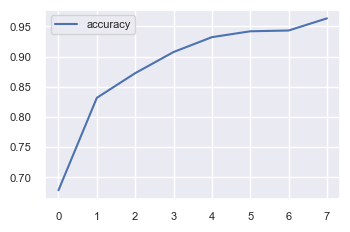

In [13]:
plt.plot(test_model.history.history["accuracy"], label="accuracy")
plt.legend()

In [14]:
best_params = study.best_params
# best_params = dict(n_conv=0, n_hidden=1, hidden_nodes=248, dropout=0.752200, filters=8, kernel_size=14, batch_size=19, epochs=75)

In [15]:
cnn = build_model((27,27), 2, **best_params)
cnn.summary()
cnn.fit( np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)), 
            epochs=best_params["epochs"], 
            batch_size=best_params["batch_size"])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 base_conv (Conv1D)          (None, 15, 14)            4928      
                                                                 
 batch_normalization_3 (Batc  (None, 15, 14)           56        
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 15, 14)            0         
                                                                 
 extra_conv_0 (Conv1D)       (None, 3, 14)             2562      
                                                                 
 batch_normalization_4 (Batc  (None, 3, 14)            56        
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 3, 14)            

In [16]:
from sklearn.metrics import f1_score, classification_report, cohen_kappa_score

y_pred = np.argmax(cnn.predict(X_test), axis=1)

print(f'Cohen k {cohen_kappa_score(y_test, y_pred)}')
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

17/17 [==============================] - 0s 2ms/step
Cohen k 0.9346153846153846
Accuracy 0.9673076923076923
F1-score [0.9672447  0.96737044]
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       260
           1       0.97      0.97      0.97       260

    accuracy                           0.97       520
   macro avg       0.97      0.97      0.97       520
weighted avg       0.97      0.97      0.97       520



   # LIME Explainer 

## try to create an rgb matrix using one trace at once

In [130]:
# for i in range(len(X_test[1]))
# Crea una matrice numpy 27x27 di valori di esempio
matrice = X_test[1].reshape(27,27)
# Normalizza la matrice tra 0 e 1
min_value = np.min(matrice)
max_value = np.max(matrice)
matrice_normalizzata = (matrice - min_value) / (max_value - min_value)

# Crea una matrice 27x27x3 con valori dei canali di colore basati sulla matrice normalizzata
rosso = matrice_normalizzata
verde = np.zeros_like(matrice_normalizzata)
blu = np.zeros_like(matrice_normalizzata)
heatmap = np.dstack((rosso, verde, blu))

# Stampa la matrice 27x27x3
# print(heatmap)
heatmap.shape

(27, 27, 3)

## setting the classifier for explain_instance using the cnn

In [18]:
from lime import lime_image
from PIL import Image

In [107]:
explainer = lime_image.LimeImageExplainer()

In [144]:

def pred_fn(imgs):
    tot_probs = []
    for img in imgs:
        probs = cnn.predict(img)[0].reshape(-1,1) #qui c'è l'inghippo credo!!!
        tot_probs.append(probs)
    return tot_probs
pred_fn([X_test[:1]])

1/1 [==============================] - 0s 38ms/step


[array([[1.1384219e-04],
        [9.9988616e-01]], dtype=float32)]

In [145]:
#try building explanation with heatmap and classifier setted before
explanation = explainer.explain_instance(heatmap, classifier_fn=pred_fn, num_samples=10)

  0%|          | 0/10 [00:00<?, ?it/s]

InvalidArgumentError: Graph execution error:

Detected at node 'sequential_1/base_conv/Conv1D' defined at (most recent call last):
    File "<frozen runpy>", line 198, in _run_module_as_main
    File "<frozen runpy>", line 88, in _run_code
    File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\ipykernel\kernelapp.py", line 725, in start
      self.io_loop.start()
    File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\emanu\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 604, in run_forever
      self._run_once()
    File "C:\Users\emanu\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "C:\Users\emanu\AppData\Local\Programs\Python\Python311\Lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\ipykernel\kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
      await result
    File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\3249444266.py", line 4, in <module>
      pred_fn(X_test)
    File "C:\Users\emanu\AppData\Local\Temp\ipykernel_33832\3249444266.py", line 2, in pred_fn
      tot_probs = cnn.predict(X_test[1].reshape(1,-1))
    File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\keras\engine\training.py", line 2382, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\keras\engine\training.py", line 2169, in predict_function
      return step_function(self, iterator)
    File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\keras\engine\training.py", line 2155, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\keras\engine\training.py", line 2143, in run_step
      outputs = model.predict_step(data)
    File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\keras\engine\training.py", line 2111, in predict_step
      return self(x, training=False)
    File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\keras\engine\training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\keras\engine\base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\keras\engine\sequential.py", line 412, in call
      return super().call(inputs, training=training, mask=mask)
    File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\keras\engine\functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\keras\engine\functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\keras\engine\base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\keras\layers\convolutional\base_conv.py", line 290, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\keras\layers\convolutional\base_conv.py", line 262, in convolution_op
      return tf.nn.convolution(
Node: 'sequential_1/base_conv/Conv1D'
input depth must be evenly divisible by filter depth: 3 vs 27
	 [[{{node sequential_1/base_conv/Conv1D}}]] [Op:__inference_predict_function_630561]

In [53]:
temp, mask = explanation.get_image_and_mask(Y_test[idx], num_features=520)

NameError: name 'explanation' is not defined

In [52]:
from skimage.segmentation import mark_boundaries

plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

NameError: name 'temp' is not defined

## The example thet seems to work with heatmap

In [32]:
from skimage.color import gray2rgb, rgb2gray, label2rgb

In [58]:
from sklearn.datasets import load_digits
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier

digits = load_digits()

for line in digits.DESCR.split("\n")[5:20]:
    print(line)

X, Y = digits.data, digits.target

print("Data Size : ", X.shape, Y.shape)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.80, test_size=0.2, stratify=Y, random_state=123)

print("Train/Test Sizes : ", X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

gb = GradientBoostingClassifier()

gb.fit(X_train, Y_train)

print("Test  Accuracy : %.2f"%gb.score(X_test, Y_test))
print("Train Accuracy : %.2f"%gb.score(X_train, Y_train))
print()
print("Confusion Matrix : ")
print(confusion_matrix(Y_test, gb.predict(X_test)))
print()
print("Classification Report")
print(classification_report(Y_test, gb.predict(X_test)))

**Data Set Characteristics:**

    :Number of Instances: 1797
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Data Size :  (1797, 64) (1797,)
Train/Test Sizes :  (1437, 64) (360, 64) (1437,) (360,)
Test  Accuracy : 0.97
Train Accuracy : 1.00

Confusion Matrix : 
[[36  0  0  0  0  0  0  0  0  0]
 [ 1 33  0  1  1  0  0  0  0  0]
 [ 0  1 34  0  0  0  0  0  0  0]
 [ 0  0  0 36  0  0  0  0  0  1]
 [ 0  0  0  0 36  0  0  0  0  0]
 [ 0  0  0  0  1 36  0  0  0  0]
 [ 0  1  0  0  0  0 34  0  1  0]
 [ 0  0  0  0  1  0  0 34  0  1]
 [ 0  1  0  0  0  0  0  0 34  0]
 [ 0  0  0  

In [82]:
# for i in range(len(X_test[1]))
# Crea una matrice numpy 27x27 di valori di esempio
matrice = X_test[1].reshape(8,8)
# Normalizza la matrice tra 0 e 1
min_value = np.min(matrice)
max_value = np.max(matrice)
matrice_normalizzata = (matrice - min_value) / (max_value - min_value)

# Crea una matrice 27x27x3 con valori dei canali di colore basati sulla matrice normalizzata
rosso = matrice_normalizzata
verde = np.zeros_like(matrice_normalizzata)
blu = np.zeros_like(matrice_normalizzata)
heatmap = np.dstack((rosso, verde, blu))

# Stampa la matrice 27x27x3
# print(heatmap)
heatmap[0]

array([[0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    ],
       [0.6875, 0.    , 0.    ],
       [1.    , 0.    , 0.    ],
       [0.5   , 0.    , 0.    ],
       [0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    ]])

In [83]:
heatmap.shape

(8, 8, 3)

In [60]:
from lime import lime_image

explainer = lime_image.LimeImageExplainer()

In [84]:
from skimage.color import gray2rgb, rgb2gray, label2rgb # since the code wants color images

def pred_fn(imgs):
    tot_probs = []
    for img in imgs:
        probs = gb.predict_proba(X_test[1].reshape(1, -1))[0]
        tot_probs.append(probs)
    return tot_probs

pred_fn([X_test[1].reshape(8,8)])

[array([6.30296654e-07, 1.66769473e-05, 1.53074127e-05, 2.54881115e-05,
        1.24870128e-05, 4.63089858e-04, 1.58560078e-06, 1.27560664e-05,
        5.36971208e-05, 9.99398282e-01])]

In [63]:
import random 

In [89]:
idx = random.randint(1, len(X_test))

print("Prediction : ", gb.predict(X_test[idx].reshape(1,-1))[0])
print("Actual :     ", Y_test[idx])

explanation = explainer.explain_instance(heatmap,
                                         classifier_fn=pred_fn)

temp, mask = explanation.get_image_and_mask(Y_test[2], num_features=64)

Prediction :  4
Actual :      4


  0%|          | 0/1000 [00:00<?, ?it/s]

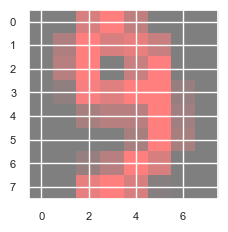

In [90]:
from skimage.segmentation import mark_boundaries

plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))